In [2]:
import pandas as pd

# Load the CSV files
clusters_df = pd.read_csv(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\kmeans_clusters_k5_named.csv")
lst_df = pd.read_csv(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\raster_stats\LST_mean_wide.csv")

# Merge on 'site_id'
merged_df = pd.merge(clusters_df, lst_df, on='site_id', how='inner')

# Optional: Display or save the result
print(merged_df.head())  # Preview the merged DataFrame

# Save to CSV
merged_df.to_csv(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\merged_clusters_LST.csv", index=False)

  site_id     (0,5]    (5,10]   (10,15]   (15,20]   (20,25]   (25,30]  \
0     130  0.821429  0.071429  0.071429  0.035714  0.000000  0.000000   
1     131  0.139344  0.295082  0.188525  0.327869  0.049180  0.000000   
2     133  0.214286  0.642857  0.142857  0.000000  0.000000  0.000000   
3     147  0.321429  0.178571  0.428571  0.071429  0.000000  0.000000   
4  AAD004  0.039312  0.447174  0.432432  0.049140  0.019656  0.012285   

   (30,35]  (35,40]  cluster  ... 2025-04-05 03:19:55  2025-04-06 10:41:38  \
0      0.0      0.0        3  ...           27.299229            28.180002   
1      0.0      0.0        1  ...           27.409046            25.018183   
2      0.0      0.0        0  ...           29.662306            27.021666   
3      0.0      0.0        1  ...           26.150002            25.710000   
4      0.0      0.0        1  ...           22.912498            22.367500   

   2025-04-09 01:45:30  2025-04-13 00:11:06  2025-04-20 21:00:26  \
0            21.119232  

In [10]:
import pandas as pd

# Load file
df = pd.read_csv(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\merged_clusters_LST.csv")

# Identify LST date columns — skip bin columns and metadata
lst_columns = []
for col in df.columns:
    try:
        # If it parses as datetime, include it
        pd.to_datetime(col)
        lst_columns.append(col)
    except:
        continue

# Melt the DataFrame: keep only site_id and cluster info as IDs
melted = df.melt(id_vars=['site_id', 'cluster_label'], value_vars=lst_columns,
                 var_name='date', value_name='LST')

# Convert date strings to datetime objects
melted['date'] = pd.to_datetime(melted['date'])

# Drop missing values (if any)
melted = melted.dropna(subset=['LST'])

# Ensure LST values are numeric
melted['LST'] = pd.to_numeric(melted['LST'], errors='coerce')

# Step 1: Compute daily average LST across all sites
daily_mean_LST = melted.groupby('date')['LST'].mean()

# Step 2: 95th percentile threshold
threshold = daily_mean_LST.quantile(0.95)
print(f"Top 5% LST threshold: {threshold:.2f} °C")

# Step 3: Identify extreme heat days
extreme_heat_dates = daily_mean_LST[daily_mean_LST > threshold].index
print(f"Number of extreme heat days: {len(extreme_heat_dates)}")

# Step 4: Add heat event flag
melted['heat_event'] = melted['date'].isin(extreme_heat_dates)
print(melted['heat_event'].value_counts())

# Step 5: Save output
output_path = r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\merged_clusters_extreme_heat.csv"
melted.to_csv(output_path, index=False)


Top 5% LST threshold: 42.70 °C
Number of extreme heat days: 15
heat_event
False    379957
True      20996
Name: count, dtype: int64


In [30]:


# Mean and std LST during heat events per cluster
summary = df_heat.groupby('cluster_label')['LST'].agg(['mean', 'std', 'count']).sort_values('mean')
print(summary)



                            mean       std  count
cluster_label                                    
10–15m dominant        44.032004  4.378102   3463
0–5m dominant          44.520573  4.554662   8487
5–10m dominant         45.044393  4.094114   8342
0–40m mixed structure  45.178703  2.303426     45
0–25m mixed structure  45.242590  4.493800    659


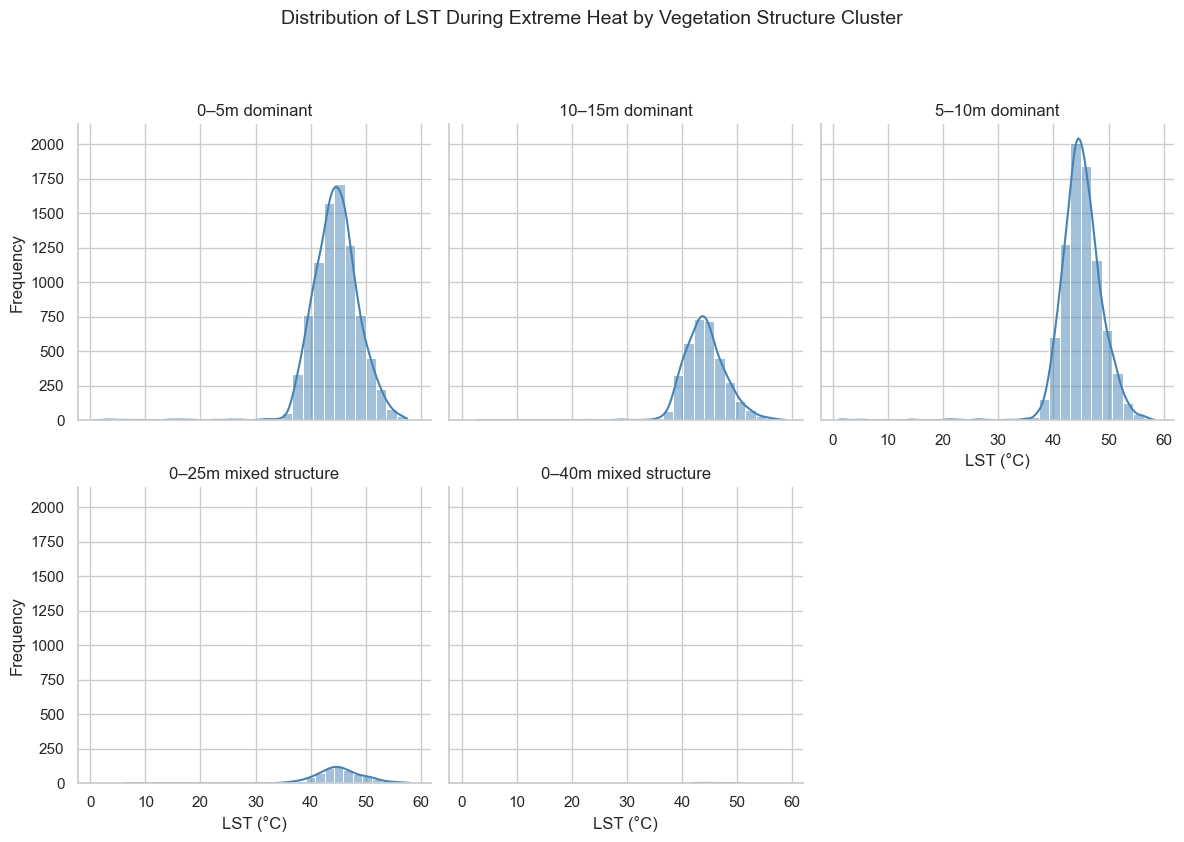

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to heat event rows (already done earlier)
# df_heat = melted[melted['heat_event'] == True]

# Set plot style
sns.set(style="whitegrid")

# Plot: Histogram of LST for each cluster
g = sns.FacetGrid(df_heat, col="cluster_label", col_wrap=3, sharex=True, sharey=True, height=4)
g.map_dataframe(sns.histplot, x="LST", bins=30, kde=True, color="steelblue")

# Customize
g.set_axis_labels("LST (°C)", "Frequency")
g.set_titles("{col_name}")
plt.suptitle("Distribution of LST During Extreme Heat by Vegetation Structure Cluster", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()



C:\Users\jbros\AppData\Local\Temp\ipykernel_15304\4003486989.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_heat, x='cluster_label', y='LST', inner='quartile', palette='Set2')


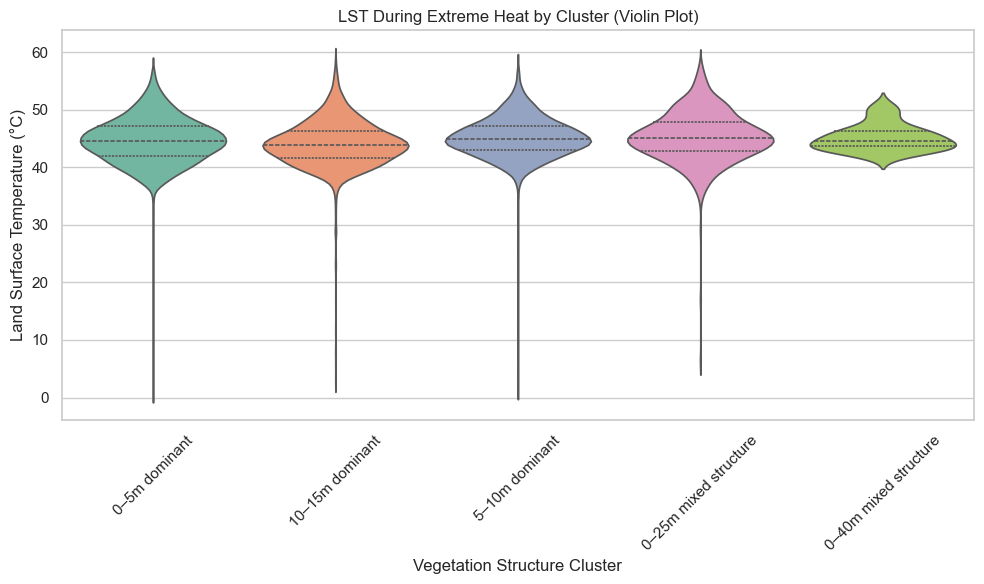

In [20]:


plt.figure(figsize=(10, 6))
sns.violinplot(data=df_heat, x='cluster_label', y='LST', inner='quartile', palette='Set2')
plt.title("LST During Extreme Heat by Cluster (Violin Plot)")
plt.xlabel("Vegetation Structure Cluster")
plt.ylabel("Land Surface Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


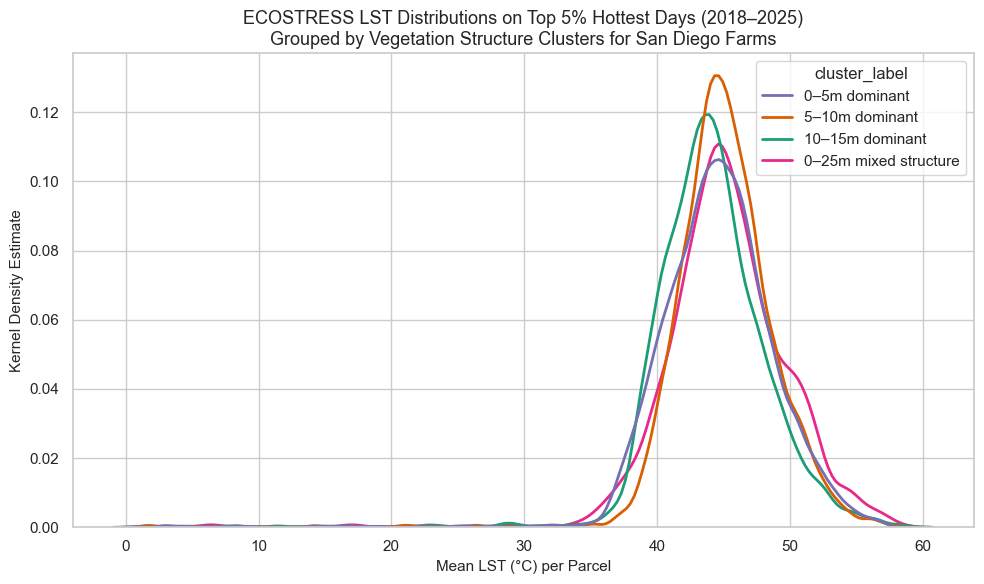

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data to heat events with valid cluster labels
df_heat = melted[(melted['heat_event']) & (melted['cluster_label'].notna())]

# Define custom color palette for clusters
custom_palette = {
    "0–5m dominant": "#7570b3",
    "5–10m dominant": "#d95f02",
    "10–15m dominant": "#1b9e77",
    "0–25m mixed structure": "#e7298a"
}

# Explicit cluster order for plotting
ordered_clusters = [
    "0–5m dominant",
    "5–10m dominant",
    "10–15m dominant",
    "0–25m mixed structure"
]

# Plot KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_heat,
    x="LST",
    hue="cluster_label",
    hue_order=ordered_clusters,
    palette=custom_palette,
    common_norm=False,
    bw_adjust=0.7,
    fill=False,
    linewidth=2
)

plt.title("ECOSTRESS LST Distributions on Top 5% Hottest Days (2018–2025)\nGrouped by Vegetation Structure Clusters for San Diego Farms", fontsize=13)
plt.xlabel("Mean LST (°C) per Parcel", fontsize=11)
plt.ylabel("Kernel Density Estimate", fontsize=11)
plt.tight_layout()
plt.show()


In [24]:
# Step 1: Compute daily mean LST across all sites
daily_mean_LST = melted.groupby('date')['LST'].mean()

# Step 2: Calculate the 5th percentile (cold threshold)
cold_threshold = daily_mean_LST.quantile(0.05)
print(f"Bottom 5% LST threshold: {cold_threshold:.2f} °C")

# Step 3: Identify extreme cold dates
extreme_cold_dates = daily_mean_LST[daily_mean_LST < cold_threshold].index
print(f"Number of extreme cold days: {len(extreme_cold_dates)}")

# Step 4: Flag each row
melted['cold_event'] = melted['date'].isin(extreme_cold_dates)
print(melted['cold_event'].value_counts())


Bottom 5% LST threshold: 6.11 °C
Number of extreme cold days: 15
cold_event
False    380027
True      20926
Name: count, dtype: int64


C:\Users\jbros\AppData\Local\Temp\ipykernel_15304\3097121987.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_cold, x='cluster_label', y='LST', inner='quartile', palette='coolwarm')


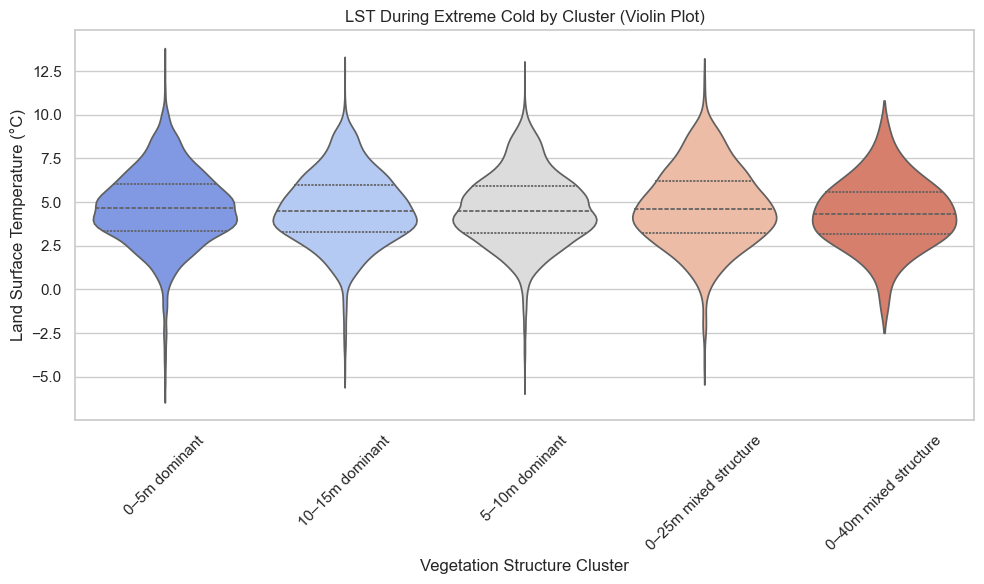

In [26]:
# Filter only cold events
df_cold = melted[(melted['cold_event']) & (melted['cluster_label'].notna())]

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_cold, x='cluster_label', y='LST', inner='quartile', palette='coolwarm')
plt.title("LST During Extreme Cold by Cluster (Violin Plot)")
plt.xlabel("Vegetation Structure Cluster")
plt.ylabel("Land Surface Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: xlabel='LST', ylabel='Density'>

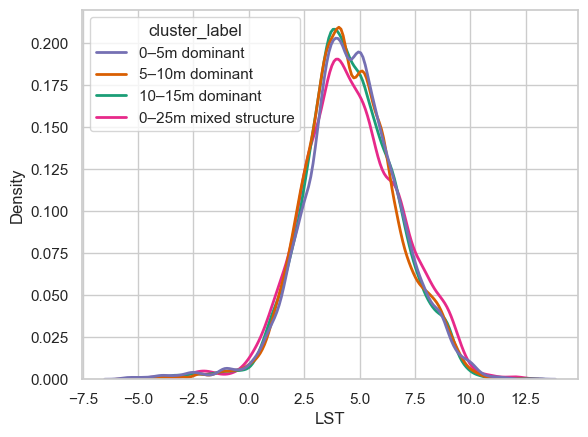

In [28]:
# KDE plot for cold days
sns.kdeplot(
    data=df_cold,
    x="LST",
    hue="cluster_label",
    hue_order=ordered_clusters,
    palette=custom_palette,
    common_norm=False,
    bw_adjust=0.7,
    fill=False,
    linewidth=2
)


C:\Users\jbros\AppData\Local\Temp\ipykernel_15304\2867093949.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=melted[melted['cluster_label'].notna()], x='cluster_label', y='LST',


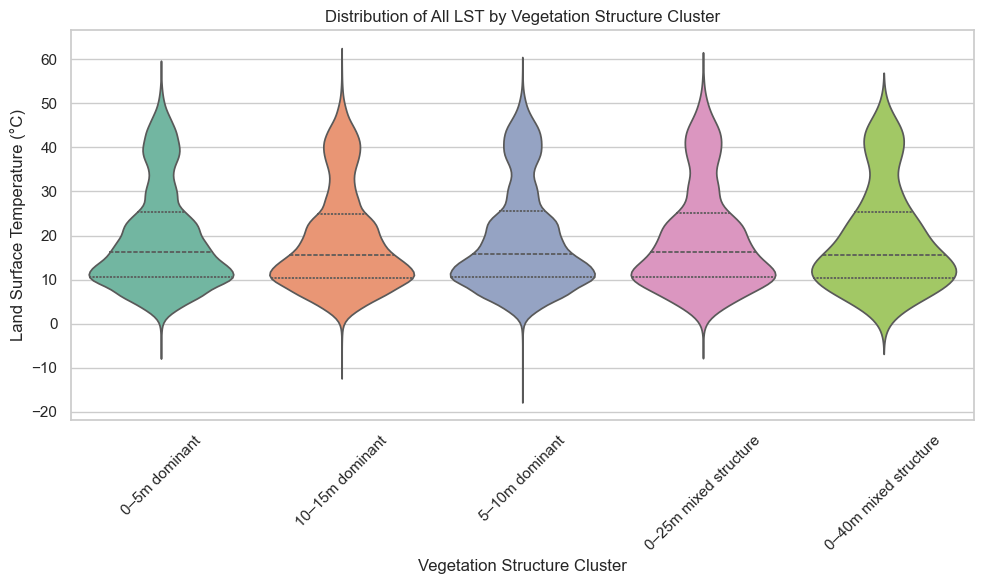

In [32]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=melted[melted['cluster_label'].notna()], x='cluster_label', y='LST',
               inner='quartile', palette='Set2')
plt.title("Distribution of All LST by Vegetation Structure Cluster")
plt.xlabel("Vegetation Structure Cluster")
plt.ylabel("Land Surface Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


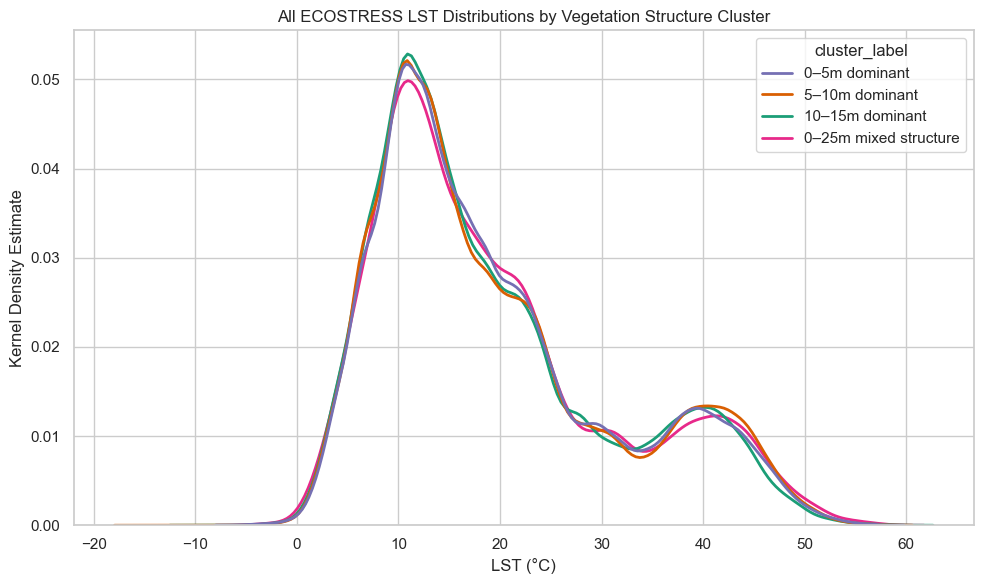

In [34]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=melted[melted['cluster_label'].notna()],
    x="LST",
    hue="cluster_label",
    hue_order=ordered_clusters,
    palette=custom_palette,
    common_norm=False,
    bw_adjust=0.7,
    fill=False,
    linewidth=2
)
plt.title("All ECOSTRESS LST Distributions by Vegetation Structure Cluster")
plt.xlabel("LST (°C)")
plt.ylabel("Kernel Density Estimate")
plt.tight_layout()
plt.show()
